## *과제에 대한 이해 (MZ 인공지능 해커톤 대회)
- 우리 과제 : **AI 장치용 STT(Speech To Text)를 위한 의도 분류 (AI-NLU with STT)**

-발화 의도 추론/분류

-**음성인식된 Text에 대하여 미디어젠 ALBERT를 통한 intention(의도=요구서비스) 분류 fine-tunning 모델 및 분류 시스템**

-문맥 분석: 하나 이상의 문장으로 구성된 텍스트 데이터를 진술, 주장, 추측, 명령, 요청 등 발화의 의도를 분석하고 구분하는 방법


-------------------------------------------


**CNN으로 문제해결하면 어떨까? 하는 궁금증*

*==> CNN으로 Sentence Classification 문제를 해결한 논문이 있었음 (Convolution Neural Networks for Sentence Classification[kim, 2014] - 인용횟수 9천회 넘음 (당시 논문은 word embedding을 직접 수행한 이후에 넣어주는 것을 추천했지만, 현재는 embedding layer에 one-hot vector을 넣어주어 구현할 것을 추천함))*

*==> CNN은 RNN에 비해 더 직관적이라는 장점이 있음*

*==> 하지만, 우리 과제는 "context(문맥) 분석"에 가깝다고 생각함. 따라서 RNN 기반이 더 적합할 것이라 생각이 듦. 왜냐하면, RNN은 문장의 문맥(Context)을 이해하는 반면, CNN은 문장 내 단어의 패턴을 인식하기 때문 (feature를 추출해주는 CNN의 성격)*


--------------------------------------------

* 성능 평가 지표

-EM (Exact matching) ?

:실제 정답과 정확하게 일치하는 비율을 의미하는 EM(Exact match) 점수

-F1 score ?

: 정밀도와 재현율을 종합적으로 고려한 수치인 F1 점수, 

-ACC ?

# 임포트

In [ ]:
import json # json 파일 불러오기 관련
import tensorflow as tf
import numpy as np
import urllib

from tensorflow.keras.preprocessing.text import Tokenizer # 전처리 관련
from tensorflow.keras.preprocessing.sequence import pad_sequences # 전처리 관련
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, Conv1D, MaxPooling1D, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from keras import optimizers, losses
from keras.optimizers import Adam

In [ ]:
#import tokenization

In [ ]:
import gc
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import sys
sys.path.append('../src')
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
#import tokenization
import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
tf.__version__

'2.4.0'

# 경로 설정

In [ ]:
train_path = 'train_data.json'
valid_path = 'dev_data.json'

# 데이터 로드

- train 데이터 불러오기

In [ ]:
# json 딕셔너리 파일에서 content 데이터만 추출

import json # import json module

train_data = []
train_data_content = []

train_y = []


# train data - 대화내용 'content' & emotion 'type'불러오기
with open(train_path) as json_file:
    json_data = json.load(json_file)

    for i in json_data: # i : dict
        temp = (i.get('talk')).get('content')
        
        if '' not in temp:
            train_data.append(temp) # "content" 만
            
            train_data_content.append(list(temp.values()))
            
            #for v1 in temp.values():
            #    train_data_content += v1
            
            train_y.append(((i.get('profile')).get('emotion')).get('type'))
        
        
    print(train_data[:5], type(train_data[0]))
    print()
    print(train_y[:5], type(train_y[0]))
    print()
    print(train_data_content[:5], type(train_data_content[0]))


[{'HS01': '기분이 좋지 않아', 'SS01': '기분이 좋지 않은 이유를 알 수 있을까요?', 'HS02': '요새 건강검진을 받았는데 건강 상태가 좋지 않아.', 'SS02': '많이 속상하시겠어요. 어디가 안 좋은가요?', 'HS03': '이곳 저곳 관리해야 할 곳이 많아.', 'SS03': '안좋은 곳이 많아 걱정이 많으시겠어요.'}, {'HS01': '진로가 너무 걱정스러워. 내가 진짜 뭘 해야 할지 모르겠어.', 'SS01': '미래가 두려우시군요. 하고 싶은 일이 있으세요?', 'HS02': '하고 싶은 일은 있는데 지금 시작하기에 너무 늦은 것 같아서 선뜻 도전을 못 하겠어.', 'SS02': '도전하는 것에 두려움을 느끼고 계시네요.', 'HS03': '', 'SS03': ''}, {'HS01': '아이가 친구랑 다퉈서 걱정이야.', 'SS01': '걱정이 되시겠군요. 아이는 어떤 상태인가요?', 'HS02': '아이도 걱정이 되는지 밥도 잘 안먹더라고.', 'SS02': '많이 걱정되시겠어요. 어떻게 하면 아이를 도와줄 수 있을까요?', 'HS03': '저녁먹고 대화를 해봐야지.', 'SS03': '대화가 잘 되었으면 좋겠어요.'}, {'HS01': '나 요새 친구들이랑 대화하는 게 어려워.', 'SS01': '친구들과 대화하는 것이 어려운 이유가 있을까요?', 'HS02': '친구가 날 안좋아 할지 걱정되고 내가 말실수는 하지 않았을까 두려워.', 'SS02': '친구와 대화하기 힘들어 많이 괴로우시겠어요.', 'HS03': '너무 속상하고 불편해.', 'SS03': '친구와 다시 편하게 대화하길 바라고 계시는군요.'}, {'HS01': '결혼 후 맞벌이를 하고 있는데 은퇴를 생각하면 어렵네.', 'SS01': '은퇴를 생각하며 걱정이 되시는군요. 은퇴를 위해 준비하신 게 있으신가요?', 'HS02': '노후대비를 생각해서 연금 저축을 들어놓은 게 있어.', 'SS02': '잘 준비하셨네요. 마음은 편안하신가요?', 'HS03': '

In [ ]:
print(type(train_data_content[0]))

<class 'list'>


In [ ]:
print(type(train_data_content[0][0]))

<class 'str'>


In [ ]:
# train_data_content list -> str 로 이어붙이기
train_data_content2 = []

for idx in range(len(train_data_content)):
    train_data_content2.append('')
    
    for elem in train_data_content[idx]:
        train_data_content2[idx] += elem
    

In [ ]:
print(train_data_content2[:5], type(train_data_content2[0]), type(train_data_content2[0][0])) # okay !

['기분이 좋지 않아기분이 좋지 않은 이유를 알 수 있을까요?요새 건강검진을 받았는데 건강 상태가 좋지 않아.많이 속상하시겠어요. 어디가 안 좋은가요?이곳 저곳 관리해야 할 곳이 많아.안좋은 곳이 많아 걱정이 많으시겠어요.', '진로가 너무 걱정스러워. 내가 진짜 뭘 해야 할지 모르겠어.미래가 두려우시군요. 하고 싶은 일이 있으세요?하고 싶은 일은 있는데 지금 시작하기에 너무 늦은 것 같아서 선뜻 도전을 못 하겠어.도전하는 것에 두려움을 느끼고 계시네요.', '아이가 친구랑 다퉈서 걱정이야.걱정이 되시겠군요. 아이는 어떤 상태인가요?아이도 걱정이 되는지 밥도 잘 안먹더라고.많이 걱정되시겠어요. 어떻게 하면 아이를 도와줄 수 있을까요?저녁먹고 대화를 해봐야지.대화가 잘 되었으면 좋겠어요.', '나 요새 친구들이랑 대화하는 게 어려워.친구들과 대화하는 것이 어려운 이유가 있을까요?친구가 날 안좋아 할지 걱정되고 내가 말실수는 하지 않았을까 두려워.친구와 대화하기 힘들어 많이 괴로우시겠어요.너무 속상하고 불편해.친구와 다시 편하게 대화하길 바라고 계시는군요.', '결혼 후 맞벌이를 하고 있는데 은퇴를 생각하면 어렵네.은퇴를 생각하며 걱정이 되시는군요. 은퇴를 위해 준비하신 게 있으신가요?노후대비를 생각해서 연금 저축을 들어놓은 게 있어.잘 준비하셨네요. 마음은 편안하신가요?이걸로 충분할지 잘 모르겠어. 불안한 마음이 자꾸 들어.미래에 대해 불안함으로 마음이 힘드시군요.'] <class 'str'> <class 'str'>


In [ ]:
len(train_data_content2) # 총 15832 개의 대화

15832

In [ ]:
# 대화 없는 발화 체크 (sanity check) -> okay !
count1 = 0

for elem in train_data_content2:
    if elem == '':
        count1 += 1
    
print(count1) # okay

0


In [ ]:
print(train_data_content2[6000:6050])

['나는 아직도 더 일할 수 있는데 벌써 은퇴라니 정말 슬퍼.아직 일할 수 있는데 은퇴하게 되어서 속상하시군요.응. 몸도 건강하고 이곳에서 젊은 시절부터 얼마나 성실하게 일했는데 이제 나가라고 하네. 이제 어떻게 해야 할지 모르겠어.젊은 시절부터 일했는데 나가라고 해서 슬프셨군요.맞아. 하지만 어떡하겠어. 회사가 어려워져서 어쩔 수 없다고 하니. 좀 쉬다가 다른 일자리가 있는지 알아봐야지.쉬다가 다른 일자리를 알아보고자 하시는군요. 생각해보 신 일자리가 있으신가요?', '나 코로나인 줄 알았는데 그냥 독감이었어. 다행이고 기뻐.코로나가 아닌 독감이어서 기쁘셨군요.코로나였으면 어쩔 뻔했어. 실은 저번에 모임에서 잠깐 마스크를 벗었거든.모임에서 마스크를 벗어서 걱정하셨군요. 이제 감기에서 나으려면 어떻게 해야 할까요?외출하면 절대로 마스크를 벗지 않을 거야.마스크를 벗지 않으며 건강을 유지하셨으면 좋겠어요.', '젊을 때는 나이들어 부유할 줄 알았는데 현실은 정반대로 돈 걱정하는 모습이 한심하게 느껴져.돈 때문에 걱정하는 모습을 스스로 한심하게 느끼시는군요.노후 준비를 했어야 하는데 이제 와서 어떻게 해야 할지 막막해.그런 부분에 대해서 조언을 구할 상대가 있을까요?투자 전문가를 만나는 건 너무 벅찰 것 같아서 친구들에게 한 번 물어봐야겠어.친구와의 대화가 도움이 되면 좋겠군요.', '내가 연애에 너무 방어적인 사람이래.무슨 일이죠? 설명해 줄 수 있나요?그냥 내 행동이나 말이 상대방이 느끼기에 방어적이래. 난 그냥 상처받고 싶지 않아서 한 행동과 말인데.상처받지 않기 위해 한 행동과 말이 상대에겐 방어적으로 느껴졌군요.맞아. 내가 잘못된 거라는 생각은 안 하는데 세상에는 원래 다양한 입장과 사람이 있는 거잖아.방어적이란 건 잘못이 아니라고 생각하시는데 주변 반응 때문에 신경쓰이셨던 것처럼 느껴지네요.', '이번 생은 망했어. 내 생에 취업이란 없나 봐.취업 때문에 걱정이 많으신가요?아주 절망적인 상황이야. 난 이렇게 늙어 죽을 거야.취업 문제로 마음이 많이 안 

- dev 데이터 불러오기

In [ ]:
# json 딕셔너리 파일에서 content 데이터만 추출

valid_data = []
valid_data_content = []
valid_y = []

# dev data - 대화내용 'content' & emotion 'type'불러오기

with open(valid_path) as json_file:
    json_data2 = json.load(json_file)

    for j in json_data2: # i : dict
        temp = (j.get('talk')).get('content')
        
        if '' not in temp:
            valid_data.append(temp) # "content" 만
            
            valid_data_content.append(list(temp.values()))
            
            #for v1 in temp.values():
            #    train_data_content += v1
            
            valid_y.append(((j.get('profile')).get('emotion')).get('type'))
        
        
    print(valid_data[:5], type(valid_data[0]))
    print()
    print(valid_y[:5], type(train_y[0]))
    print()
    print(valid_data_content[:5], type(valid_data_content[0]))

[{'HS01': '노후준비 하기가 정말 어렵네.', 'SS01': '제일 걱정이 뭐세요?', 'HS02': '돈이 제일 문제야.', 'SS02': '지금 노후준비 하고 계신건가요?', 'HS03': '적금이나 저축을 하긴 했는데 얼마 안되니까 문제지.', 'SS03': '저축을 해도 금액적으로 액수가 적은것 같다고 생각하시는군요.'}, {'HS01': '나이가 드니까 건강이 걱정스러워. 친한 친구가 암에 걸렸거든.', 'SS01': '친구가 암에 걸려서 건강에 대한 걱정이 많아지셨군요. 혹시 지금 아픈 곳이 있으신가요?', 'HS02': '아니. 아픈 곳은 없는데 건강 걱정이 늘었지.', 'SS02': '혹시 이 문제로 상담할 만한 전문가가 주변에 계실까요?', 'HS03': '', 'SS03': ''}, {'HS01': '남자친구랑 십 년 가까이 만났는데 결혼적령기가 되니 결혼해도 될지 고민되네.', 'SS01': '결혼을 생각할 때 걱정되는 부분이 있는 건가요?', 'HS02': '좋은 부분도 많지만 술 마시는 날은 연락이 안되는 문제가 있어서 걱정이야.', 'SS02': '술 마시면 불안하게 걱정을 시키군요.', 'HS03': '이런 사람이랑 결혼을 해도 될까?', 'SS03': '남자친구와 걱정되는 부분에 대해 고민을 나눠보세요.'}, {'HS01': '걱정이 하나 있어.', 'SS01': '어떤 걱정인지 여쭤봐도 될까요?', 'HS02': '다들 새로운 친구를 잘 사귀는데 나만 아무도 만나지 못하는 것 같아.', 'SS02': '새로운 인간 관계를 맺지 못해 걱정이 되시나봐요.', 'HS03': '응. 이러다 나만 혼자가 될 것 같아 불안해.', 'SS03': '불안감을 많이 느끼고 계시군요.'}, {'HS01': '요즘 젊은 직원들은 도대체 이해할 수 없어', 'SS01': '직원들과 무슨일이 있으셨나봐요.', 'HS02': '왜이렇게 다들 느긋한지 일에 대해 제대로 하는 것도 없는것 같고 나만 안달난 기분이야.', 'SS02': '혼자만 마음이 

In [ ]:
print(type(valid_data_content[0]))

<class 'list'>


In [ ]:
print(type(valid_data_content[0][0]))

<class 'str'>


In [ ]:
# dev_data_content list -> str 로 이어붙이기
valid_data_content2 = []

for idx in range(len(valid_data_content)):
    valid_data_content2.append('')
    
    for elem in valid_data_content[idx]:
        valid_data_content2[idx] += elem
    

In [ ]:
print(valid_data_content2[:5], type(valid_data_content2[0]), type(valid_data_content2[0][0])) # okay !

['노후준비 하기가 정말 어렵네.제일 걱정이 뭐세요?돈이 제일 문제야.지금 노후준비 하고 계신건가요?적금이나 저축을 하긴 했는데 얼마 안되니까 문제지.저축을 해도 금액적으로 액수가 적은것 같다고 생각하시는군요.', '나이가 드니까 건강이 걱정스러워. 친한 친구가 암에 걸렸거든.친구가 암에 걸려서 건강에 대한 걱정이 많아지셨군요. 혹시 지금 아픈 곳이 있으신가요?아니. 아픈 곳은 없는데 건강 걱정이 늘었지.혹시 이 문제로 상담할 만한 전문가가 주변에 계실까요?', '남자친구랑 십 년 가까이 만났는데 결혼적령기가 되니 결혼해도 될지 고민되네.결혼을 생각할 때 걱정되는 부분이 있는 건가요?좋은 부분도 많지만 술 마시는 날은 연락이 안되는 문제가 있어서 걱정이야.술 마시면 불안하게 걱정을 시키군요.이런 사람이랑 결혼을 해도 될까?남자친구와 걱정되는 부분에 대해 고민을 나눠보세요.', '걱정이 하나 있어.어떤 걱정인지 여쭤봐도 될까요?다들 새로운 친구를 잘 사귀는데 나만 아무도 만나지 못하는 것 같아.새로운 인간 관계를 맺지 못해 걱정이 되시나봐요.응. 이러다 나만 혼자가 될 것 같아 불안해.불안감을 많이 느끼고 계시군요.', '요즘 젊은 직원들은 도대체 이해할 수 없어직원들과 무슨일이 있으셨나봐요.왜이렇게 다들 느긋한지 일에 대해 제대로 하는 것도 없는것 같고 나만 안달난 기분이야.혼자만 마음이 급하신것 같아서 기분이 언짢아 보이시네요.'] <class 'str'> <class 'str'>


In [ ]:
valid_y[:100]

['E37',
 'E37',
 'E37',
 'E37',
 'E37',
 'E24',
 'E31',
 'E13',
 'E24',
 'E36',
 'E19',
 'E12',
 'E31',
 'E21',
 'E11',
 'E12',
 'E43',
 'E49',
 'E43',
 'E44',
 'E39',
 'E17',
 'E37',
 'E32',
 'E44',
 'E12',
 'E53',
 'E21',
 'E12',
 'E44',
 'E48',
 'E47',
 'E13',
 'E40',
 'E61',
 'E50',
 'E61',
 'E61',
 'E61',
 'E44',
 'E61',
 'E15',
 'E26',
 'E65',
 'E59',
 'E64',
 'E43',
 'E61',
 'E67',
 'E32',
 'E28',
 'E20',
 'E47',
 'E40',
 'E21',
 'E32',
 'E20',
 'E48',
 'E64',
 'E21',
 'E57',
 'E55',
 'E17',
 'E51',
 'E34',
 'E64',
 'E39',
 'E51',
 'E48',
 'E13',
 'E18',
 'E58',
 'E35',
 'E64',
 'E34',
 'E55',
 'E23',
 'E24',
 'E49',
 'E48',
 'E63',
 'E42',
 'E53',
 'E61',
 'E50',
 'E39',
 'E26',
 'E68',
 'E68',
 'E23',
 'E12',
 'E59',
 'E26',
 'E36',
 'E27',
 'E19',
 'E65',
 'E17',
 'E34',
 'E22']

In [ ]:
len(valid_data_content2) # 총 1717 번의 주고 받은 대화

1717

In [ ]:
# 대화 없는 발화 체크 (sanity check) -> okay !
count = 0

for n in valid_data_content2:
    if n == '':
        count += 1
    
print(count) # okay !

0


In [ ]:
# content 길이 간단한 EDA (train 데이터)

train_data_content_len = []
for a in train_data_content2:
    train_data_content_len.append(len(a))

train_data_content_len[:10]

[122, 128, 128, 148, 173, 170, 161, 209, 108, 192]

In [ ]:
train_data_content_len = np.array(train_data_content_len)

print(train_data_content_len.mean(),
train_data_content_len.min(),
train_data_content_len.max()) # 최대 495 음절

167.71532339565437 37 495


In [ ]:
# content 길이 간단한 EDA (valid 데이터)

valid_data_content_len = []
for a in valid_data_content2:
    valid_data_content_len.append(len(a))

valid_data_content_len[:10]

[115, 137, 175, 134, 119, 93, 129, 144, 151, 156]

In [ ]:
valid_data_content_len = np.array(valid_data_content_len)

print(valid_data_content_len.mean(),
valid_data_content_len.min(),
valid_data_content_len.max()) # 최대 421 음절

167.10017472335468 46 421


In [ ]:
print(len(train_y), len(valid_y))

15832 1717


In [ ]:
type(train_y) # 원래 => list

list

In [ ]:
type(train_y[0])

str

# *12/28 발표 내용 (주제: 한국어 전처리 방식 조사)

## **[1.분절]**
분절에는 크게
- 1-1.Sentence Segmentation
와
- 1-2.Tokenization
이 있음

1-1.문장단위 분절 (Sentence Segmentation)

- '문장단위 분절'을 하는 이유

: 한 라인에는 한 문장만 있어야 함 (**1 sentence / line**)

** **

- 자연어 처리 toolkit 중 **'NLTK'**(3.2.5버전 추천) 이용 가능

: from nltk.tokenize import sent_tokenize*

+) 문장이 이미 한 줄에 한 문장으로 존재해있으면 1-1.문장단위 분절 (Sentence Segmentation) 단계 생략 가능

* 예: 데이콘 예제

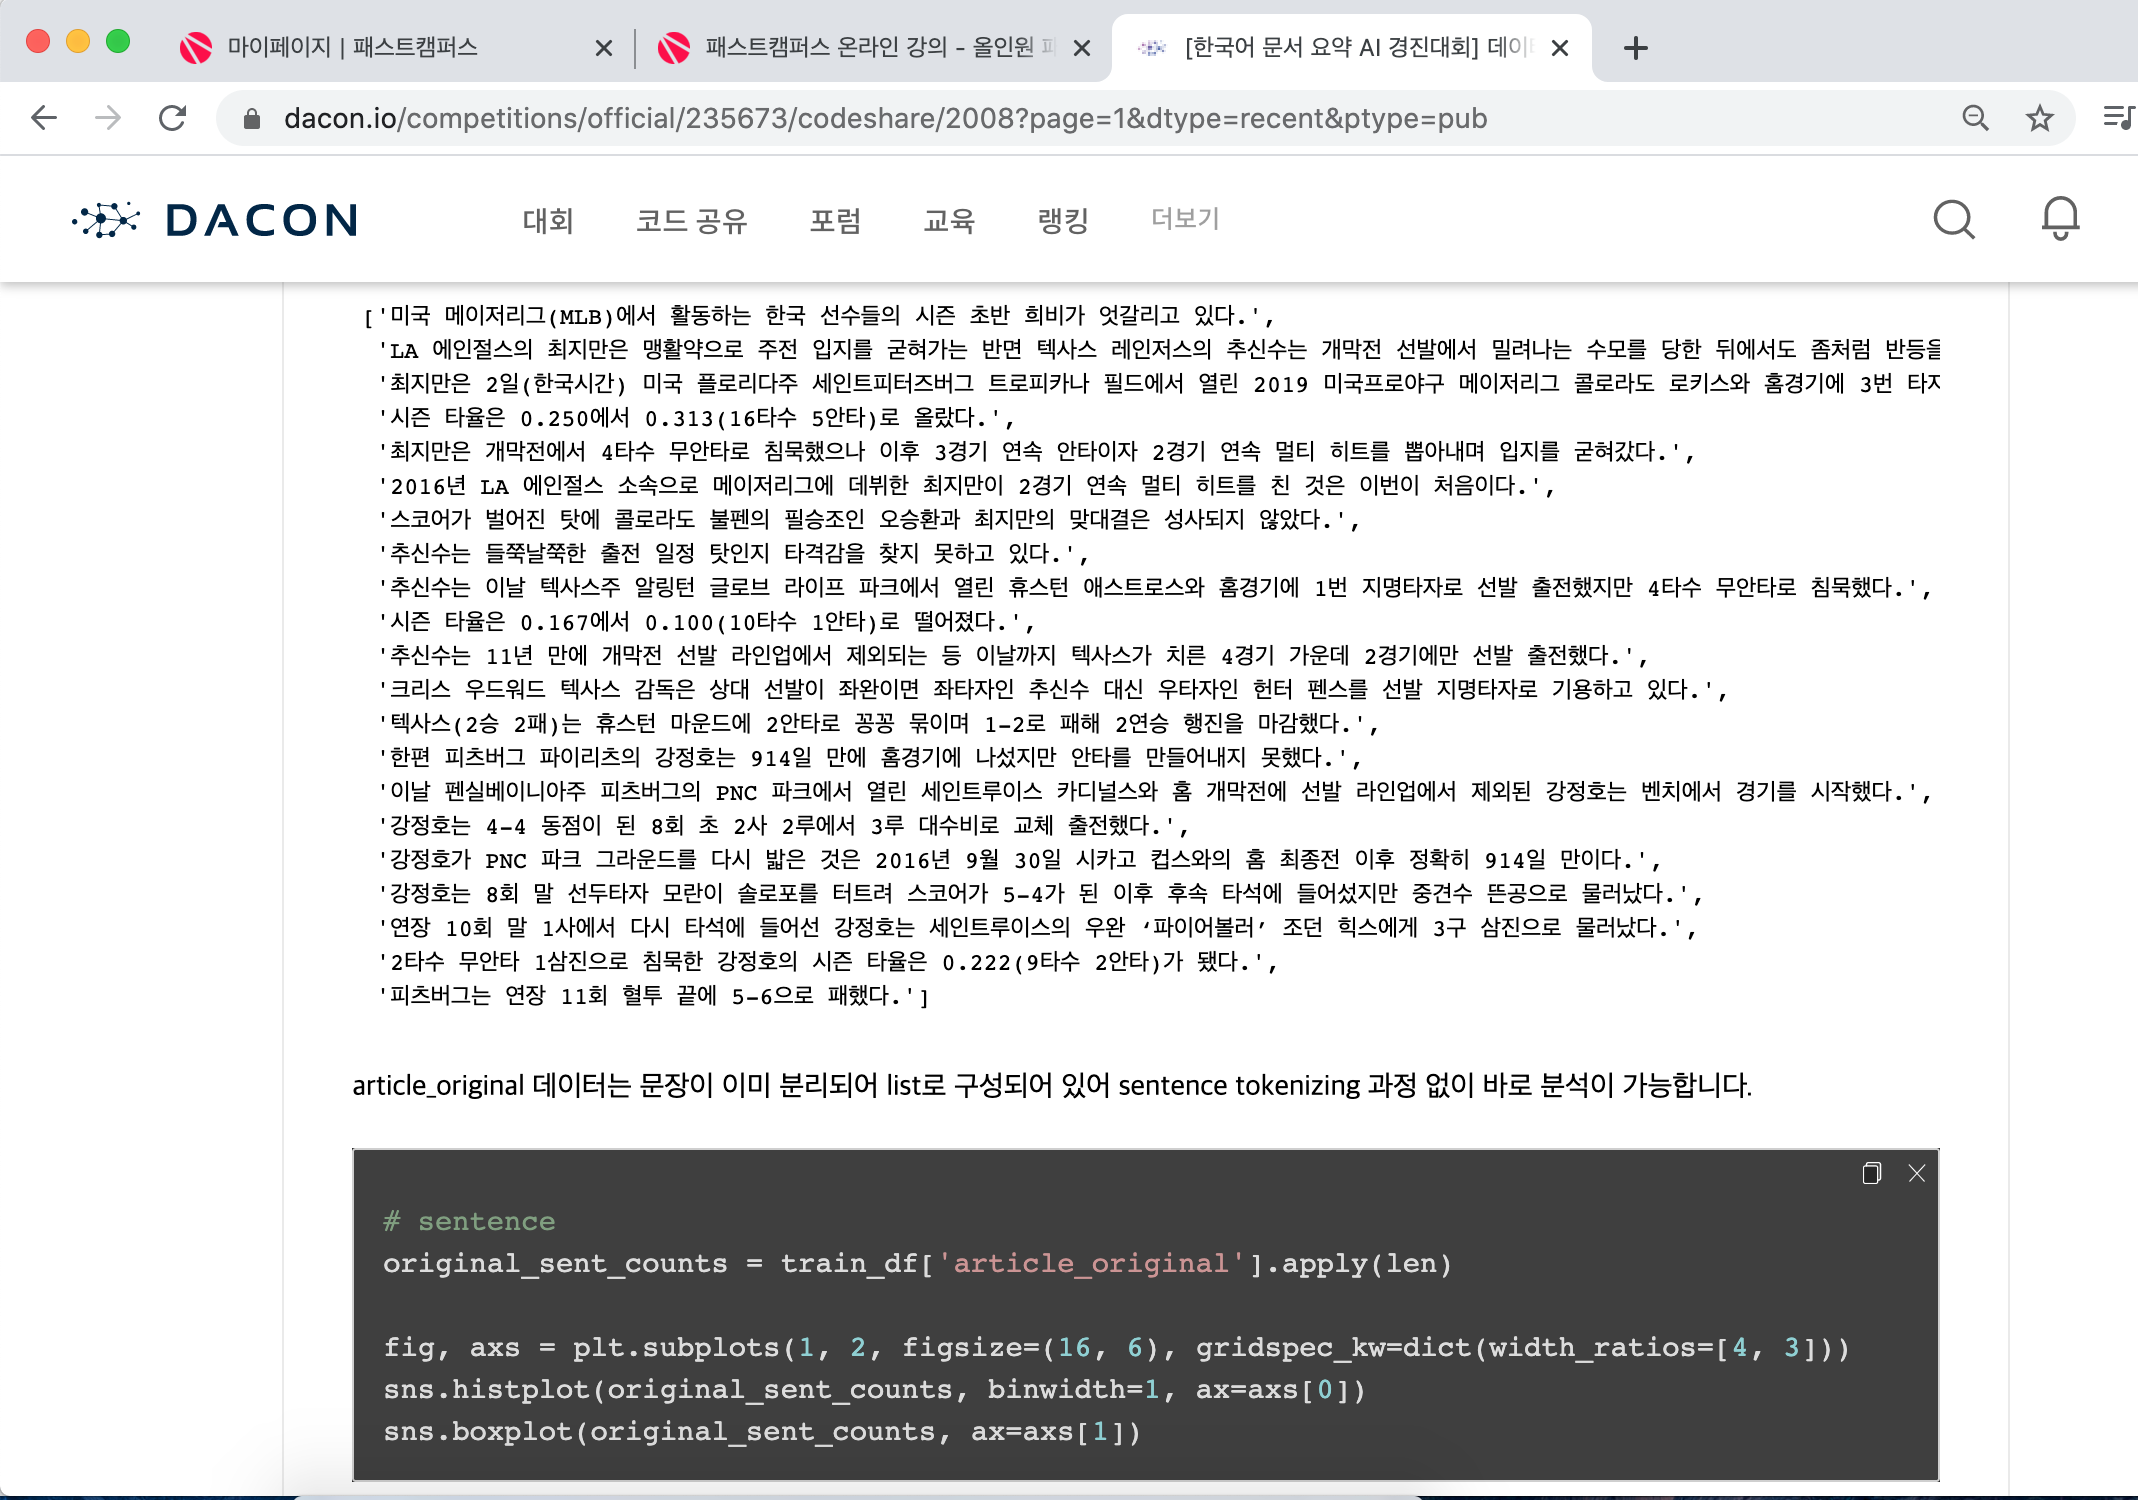

In [ ]:
train_path = 'train_data.json'
valid_path = 'dev_data.json'

In [ ]:
#### 데이터 불러오기
# json 딕셔너리 파일에서 content 데이터만 추출

import json # import json module

train_data = []
train_data_content = []

train_y = []


# train data - 대화내용 'content' & emotion 'type'불러오기
with open(train_path) as json_file:
    json_data = json.load(json_file)

    for i in json_data: # i : dict
        temp = (i.get('talk')).get('content')
        
        if '' not in temp:
            train_data.append(temp) # "content" 만
            
            train_data_content.append(list(temp.values()))
            
            #for v1 in temp.values():
            #    train_data_content += v1
            
            train_y.append(((i.get('profile')).get('emotion')).get('type'))
        
        
    print(train_data[:5], type(train_data[0]))
    print()
    print(train_y[:5], type(train_y[0]))
    print()
    print(train_data_content[:5], type(train_data_content[0]))



[{'HS01': '기분이 좋지 않아', 'SS01': '기분이 좋지 않은 이유를 알 수 있을까요?', 'HS02': '요새 건강검진을 받았는데 건강 상태가 좋지 않아.', 'SS02': '많이 속상하시겠어요. 어디가 안 좋은가요?', 'HS03': '이곳 저곳 관리해야 할 곳이 많아.', 'SS03': '안좋은 곳이 많아 걱정이 많으시겠어요.'}, {'HS01': '진로가 너무 걱정스러워. 내가 진짜 뭘 해야 할지 모르겠어.', 'SS01': '미래가 두려우시군요. 하고 싶은 일이 있으세요?', 'HS02': '하고 싶은 일은 있는데 지금 시작하기에 너무 늦은 것 같아서 선뜻 도전을 못 하겠어.', 'SS02': '도전하는 것에 두려움을 느끼고 계시네요.', 'HS03': '', 'SS03': ''}, {'HS01': '아이가 친구랑 다퉈서 걱정이야.', 'SS01': '걱정이 되시겠군요. 아이는 어떤 상태인가요?', 'HS02': '아이도 걱정이 되는지 밥도 잘 안먹더라고.', 'SS02': '많이 걱정되시겠어요. 어떻게 하면 아이를 도와줄 수 있을까요?', 'HS03': '저녁먹고 대화를 해봐야지.', 'SS03': '대화가 잘 되었으면 좋겠어요.'}, {'HS01': '나 요새 친구들이랑 대화하는 게 어려워.', 'SS01': '친구들과 대화하는 것이 어려운 이유가 있을까요?', 'HS02': '친구가 날 안좋아 할지 걱정되고 내가 말실수는 하지 않았을까 두려워.', 'SS02': '친구와 대화하기 힘들어 많이 괴로우시겠어요.', 'HS03': '너무 속상하고 불편해.', 'SS03': '친구와 다시 편하게 대화하길 바라고 계시는군요.'}, {'HS01': '결혼 후 맞벌이를 하고 있는데 은퇴를 생각하면 어렵네.', 'SS01': '은퇴를 생각하며 걱정이 되시는군요. 은퇴를 위해 준비하신 게 있으신가요?', 'HS02': '노후대비를 생각해서 연금 저축을 들어놓은 게 있어.', 'SS02': '잘 준비하셨네요. 마음은 편안하신가요?', 'HS03': '

In [ ]:
# train_data_content list -> str 로 이어붙이기
train_data_content2 = []

for idx in range(len(train_data_content)):
    train_data_content2.append('')
    
    for elem in train_data_content[idx]:
        train_data_content2[idx] += elem + '\n' # nltk 라이브러리 쓰는 거 실패해서 야매로 여기서라도 줄 바꿔줌
        
    

In [ ]:
print(train_data_content2[1]) # 결과: 사람, AI 시스템 (발화자) 별로 sentence 분절되어 있음

진로가 너무 걱정스러워. 내가 진짜 뭘 해야 할지 모르겠어.
미래가 두려우시군요. 하고 싶은 일이 있으세요?
하고 싶은 일은 있는데 지금 시작하기에 너무 늦은 것 같아서 선뜻 도전을 못 하겠어.
도전하는 것에 두려움을 느끼고 계시네요.





In [ ]:
print(train_data_content2[:5])

['기분이 좋지 않아\n기분이 좋지 않은 이유를 알 수 있을까요?\n요새 건강검진을 받았는데 건강 상태가 좋지 않아.\n많이 속상하시겠어요. 어디가 안 좋은가요?\n이곳 저곳 관리해야 할 곳이 많아.\n안좋은 곳이 많아 걱정이 많으시겠어요.\n', '진로가 너무 걱정스러워. 내가 진짜 뭘 해야 할지 모르겠어.\n미래가 두려우시군요. 하고 싶은 일이 있으세요?\n하고 싶은 일은 있는데 지금 시작하기에 너무 늦은 것 같아서 선뜻 도전을 못 하겠어.\n도전하는 것에 두려움을 느끼고 계시네요.\n\n\n', '아이가 친구랑 다퉈서 걱정이야.\n걱정이 되시겠군요. 아이는 어떤 상태인가요?\n아이도 걱정이 되는지 밥도 잘 안먹더라고.\n많이 걱정되시겠어요. 어떻게 하면 아이를 도와줄 수 있을까요?\n저녁먹고 대화를 해봐야지.\n대화가 잘 되었으면 좋겠어요.\n', '나 요새 친구들이랑 대화하는 게 어려워.\n친구들과 대화하는 것이 어려운 이유가 있을까요?\n친구가 날 안좋아 할지 걱정되고 내가 말실수는 하지 않았을까 두려워.\n친구와 대화하기 힘들어 많이 괴로우시겠어요.\n너무 속상하고 불편해.\n친구와 다시 편하게 대화하길 바라고 계시는군요.\n', '결혼 후 맞벌이를 하고 있는데 은퇴를 생각하면 어렵네.\n은퇴를 생각하며 걱정이 되시는군요. 은퇴를 위해 준비하신 게 있으신가요?\n노후대비를 생각해서 연금 저축을 들어놓은 게 있어.\n잘 준비하셨네요. 마음은 편안하신가요?\n이걸로 충분할지 잘 모르겠어. 불안한 마음이 자꾸 들어.\n미래에 대해 불안함으로 마음이 힘드시군요.\n']


In [ ]:
## (실패)

from nltk.tokenize import sent_tokenize



# train_data_content list -> str 로 이어붙이기

for idx in range(len(train_data_content)):
    train_data_content2.append('')
    
    buf = []
    
    for elem in train_data_content[idx]:
        buf += [elem]
        sentences = sent_tokenize(" ".join(buf))
        
        if len(sentences) > 1:
            buf = sentences[-1:]
            train_data_content2[idx] += '\n'.join(\sentences[:-1]) + '\n'
            
    train_data_content2[idx].append(' '.join(buf) + '\n')

SyntaxError: ignored

1-2.분절 (Tokenization)

- '분절'을 하는 이유
: 2개 이상의 다른 token들의 결합으로 이루어진 단어를 쪼개어, Vocabulary 숫자를 줄이고, 희소성(Sparseness)을 낮추기 위함

# 한국어 분절 (Korean Tokenization)
- 1.**표준화된 띄어쓰기**로 통일해주는 효과 (정규화 효과)

-일본어, 중국어는 띄어쓰기 없음

-한국어는 띄어쓰기 있으며, 표준화 과정이 아직 충분히 않아 띄어쓰기가 중구난방인 경우가 많음 & 그리고 특히 한국어의 띄어쓰기는 문장의 의미 해석에 큰 영향을 끼치지 않음

** **
- 2.**교착어**로서 갖는 성격을, 접사와 어근을 분리해줌으로써 해결 => 이는 희소성 문제를 해소하기도 함

# 사용 가능한 오픈 소스
- 1.**Mecab**

: 한국어 분절에 가장 많이 사용되는 프로그램 (일본어 형태소 분석기이나, 한국어에도 잘먹혀 널리 사용, C++ 기반으로 속도 빨라 대용량 코퍼스 처리에 적합)


- 2.**KoNLPy**

: 여러 한국어 형태소 분석기들을 모아놓은 랩핑 라이브러리 제공 (파이썬 언어여서 integration 용이한 경우 많을 것, pip 설치 가능) 

In [ ]:
# Mecab 설치
$ sudo apt-get install curl
$ bash <(curl -s http://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

+) 설치 진짜 까다로움 ;;;
- 맥 설치 참고(https://buttercoconut.xyz/251/)

=> 그냥 konlpy에서 mecab import해서 사용 권장

In [ ]:
## KoNLPy 적용

!pip install konlpy
#import konlpy


from konlpy.tag import Kkma
kkma = Kkma()



     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 
     |████████████████████████████████| 460kB 41.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


여기서부턴 데이콘 참고
(https://dacon.io/competitions/official/235670/codeshare/1823?page=1&dtype=recent&ptype=pub)



***이 외에도 Twitter, Komoran, Hannanum 등의 형태소 분석기(Pos Tagger)들이 존재합니다. 속도와 정확도 면에서 차이가 있으며 주로 Mecab 분석기를 이용합니다. 개인적인 경험에 기반한 결과를 공유하겠습니다.

- Mecab: 굉장히 속도가 빠르면서도 좋은 분석 결과를 보여준다.
- Komoran: 댓글과 같이 정제되지 않은 글에 대해서 먼저 사용해보면 좋다.(오탈자를 어느정도 고려해준다.)
- Kkma: 분석 시간이 오래걸리기 때문에 잘 이용하지 않게 된다.
- Okt: 품사 태깅 결과를 Noun, Verb등 알아보기 쉽게 반환해준다.
- khaiii: 카카오에서 가장 최근에 공개한 분석기, 성능이 좋다고 알려져 있으며 다양한 실험이 필요하다.


## 1-1. Kkma()


In [ ]:
# 형태소 단위로 문장 분리 (너무 오래걸림)


# train_data_content list -> str 로 이어붙이기
train_data_content2_konlpy1 = []

for corpus in train_data_content2:
    train_data_content2_konlpy1.append(kkma.morphs(corpus)) ## list만 가능(str 안됨)
    

KeyboardInterrupt: ignored

In [ ]:
# 예시 1) 형태소 단위로 문장 분리
result = kkma.morphs(train_data_content2[0])
print(result)

['기분', '이', '좋', '지', '않', '아', '기분', '이', '좋', '지', '않', '은', '이유', '를', '알', 'ㄹ', '수', '있', '을까요', '?', '요새', '건강', '검진', '을', '받', '았', '는데', '건강', '상태', '가', '좋', '지', '않', '아', '.', '많이', '속상하', '시', '겠', '어요', '.', '어디', '가', '안', '좋', '은가요', '?', '이곳', '저곳', '관리', '하', '어야', '하', 'ㄹ', '곳', '이', '많', '아', '.', '안', '좋', '은', '곳', '이', '많', '아', '걱정', '이', '많', '으시', '겠', '어요', '.']


In [ ]:
# 예시 2) 문장에서 명사 추출
result = kkma.nouns(train_data_content2[0])
print(result)

['기분', '이유', '수', '요새', '건강', '건강검진', '검진', '상태', '어디', '이곳', '저곳', '관리', '곳', '걱정']


In [ ]:
# 예시 3) 품사 태깅(PoS)
result = kkma.pos(train_data_content2[0])
print(result)

[('기분', 'NNG'), ('이', 'JKS'), ('좋', 'VA'), ('지', 'ECD'), ('않', 'VXV'), ('아', 'ECD'), ('기분', 'NNG'), ('이', 'JKS'), ('좋', 'VA'), ('지', 'ECD'), ('않', 'VXV'), ('은', 'ETD'), ('이유', 'NNG'), ('를', 'JKO'), ('알', 'VV'), ('ㄹ', 'ETD'), ('수', 'NNB'), ('있', 'VV'), ('을까요', 'EFQ'), ('?', 'SF'), ('요새', 'NNG'), ('건강', 'NNG'), ('검진', 'NNG'), ('을', 'JKO'), ('받', 'VV'), ('았', 'EPT'), ('는데', 'ECD'), ('건강', 'NNG'), ('상태', 'NNG'), ('가', 'JKS'), ('좋', 'VA'), ('지', 'ECD'), ('않', 'VXV'), ('아', 'ECD'), ('.', 'SF'), ('많이', 'MAG'), ('속상하', 'VA'), ('시', 'EPH'), ('겠', 'EPT'), ('어요', 'EFN'), ('.', 'SF'), ('어디', 'NP'), ('가', 'JKS'), ('안', 'MAG'), ('좋', 'VA'), ('은가요', 'EFQ'), ('?', 'SF'), ('이곳', 'NP'), ('저곳', 'NP'), ('관리', 'NNG'), ('하', 'XSV'), ('어야', 'ECD'), ('하', 'VV'), ('ㄹ', 'ETD'), ('곳', 'NNG'), ('이', 'JKS'), ('많', 'VA'), ('아', 'ECD'), ('.', 'SF'), ('안', 'MAG'), ('좋', 'VA'), ('은', 'ETD'), ('곳', 'NNG'), ('이', 'JKS'), ('많', 'VA'), ('아', 'ECD'), ('걱정', 'NNG'), ('이', 'JKS'), ('많', 'VA'), ('으시', 'EPH'), ('겠', 'EPT'), ('

## 형태소 분석 및 품사 태깅(POS Tagger)
- **형태소 분석** : 형태소를 비롯하여, 어근 접두사/접미사, 품사(POS, Part-of-Speech) 등 다양한 언어적 속성의 구조를 파악하는 것

- **품사 태깅** : 형태소의 뜻과 문맥을 고려하여 그것을 마크업 하는 일

*품사 태깅 예제
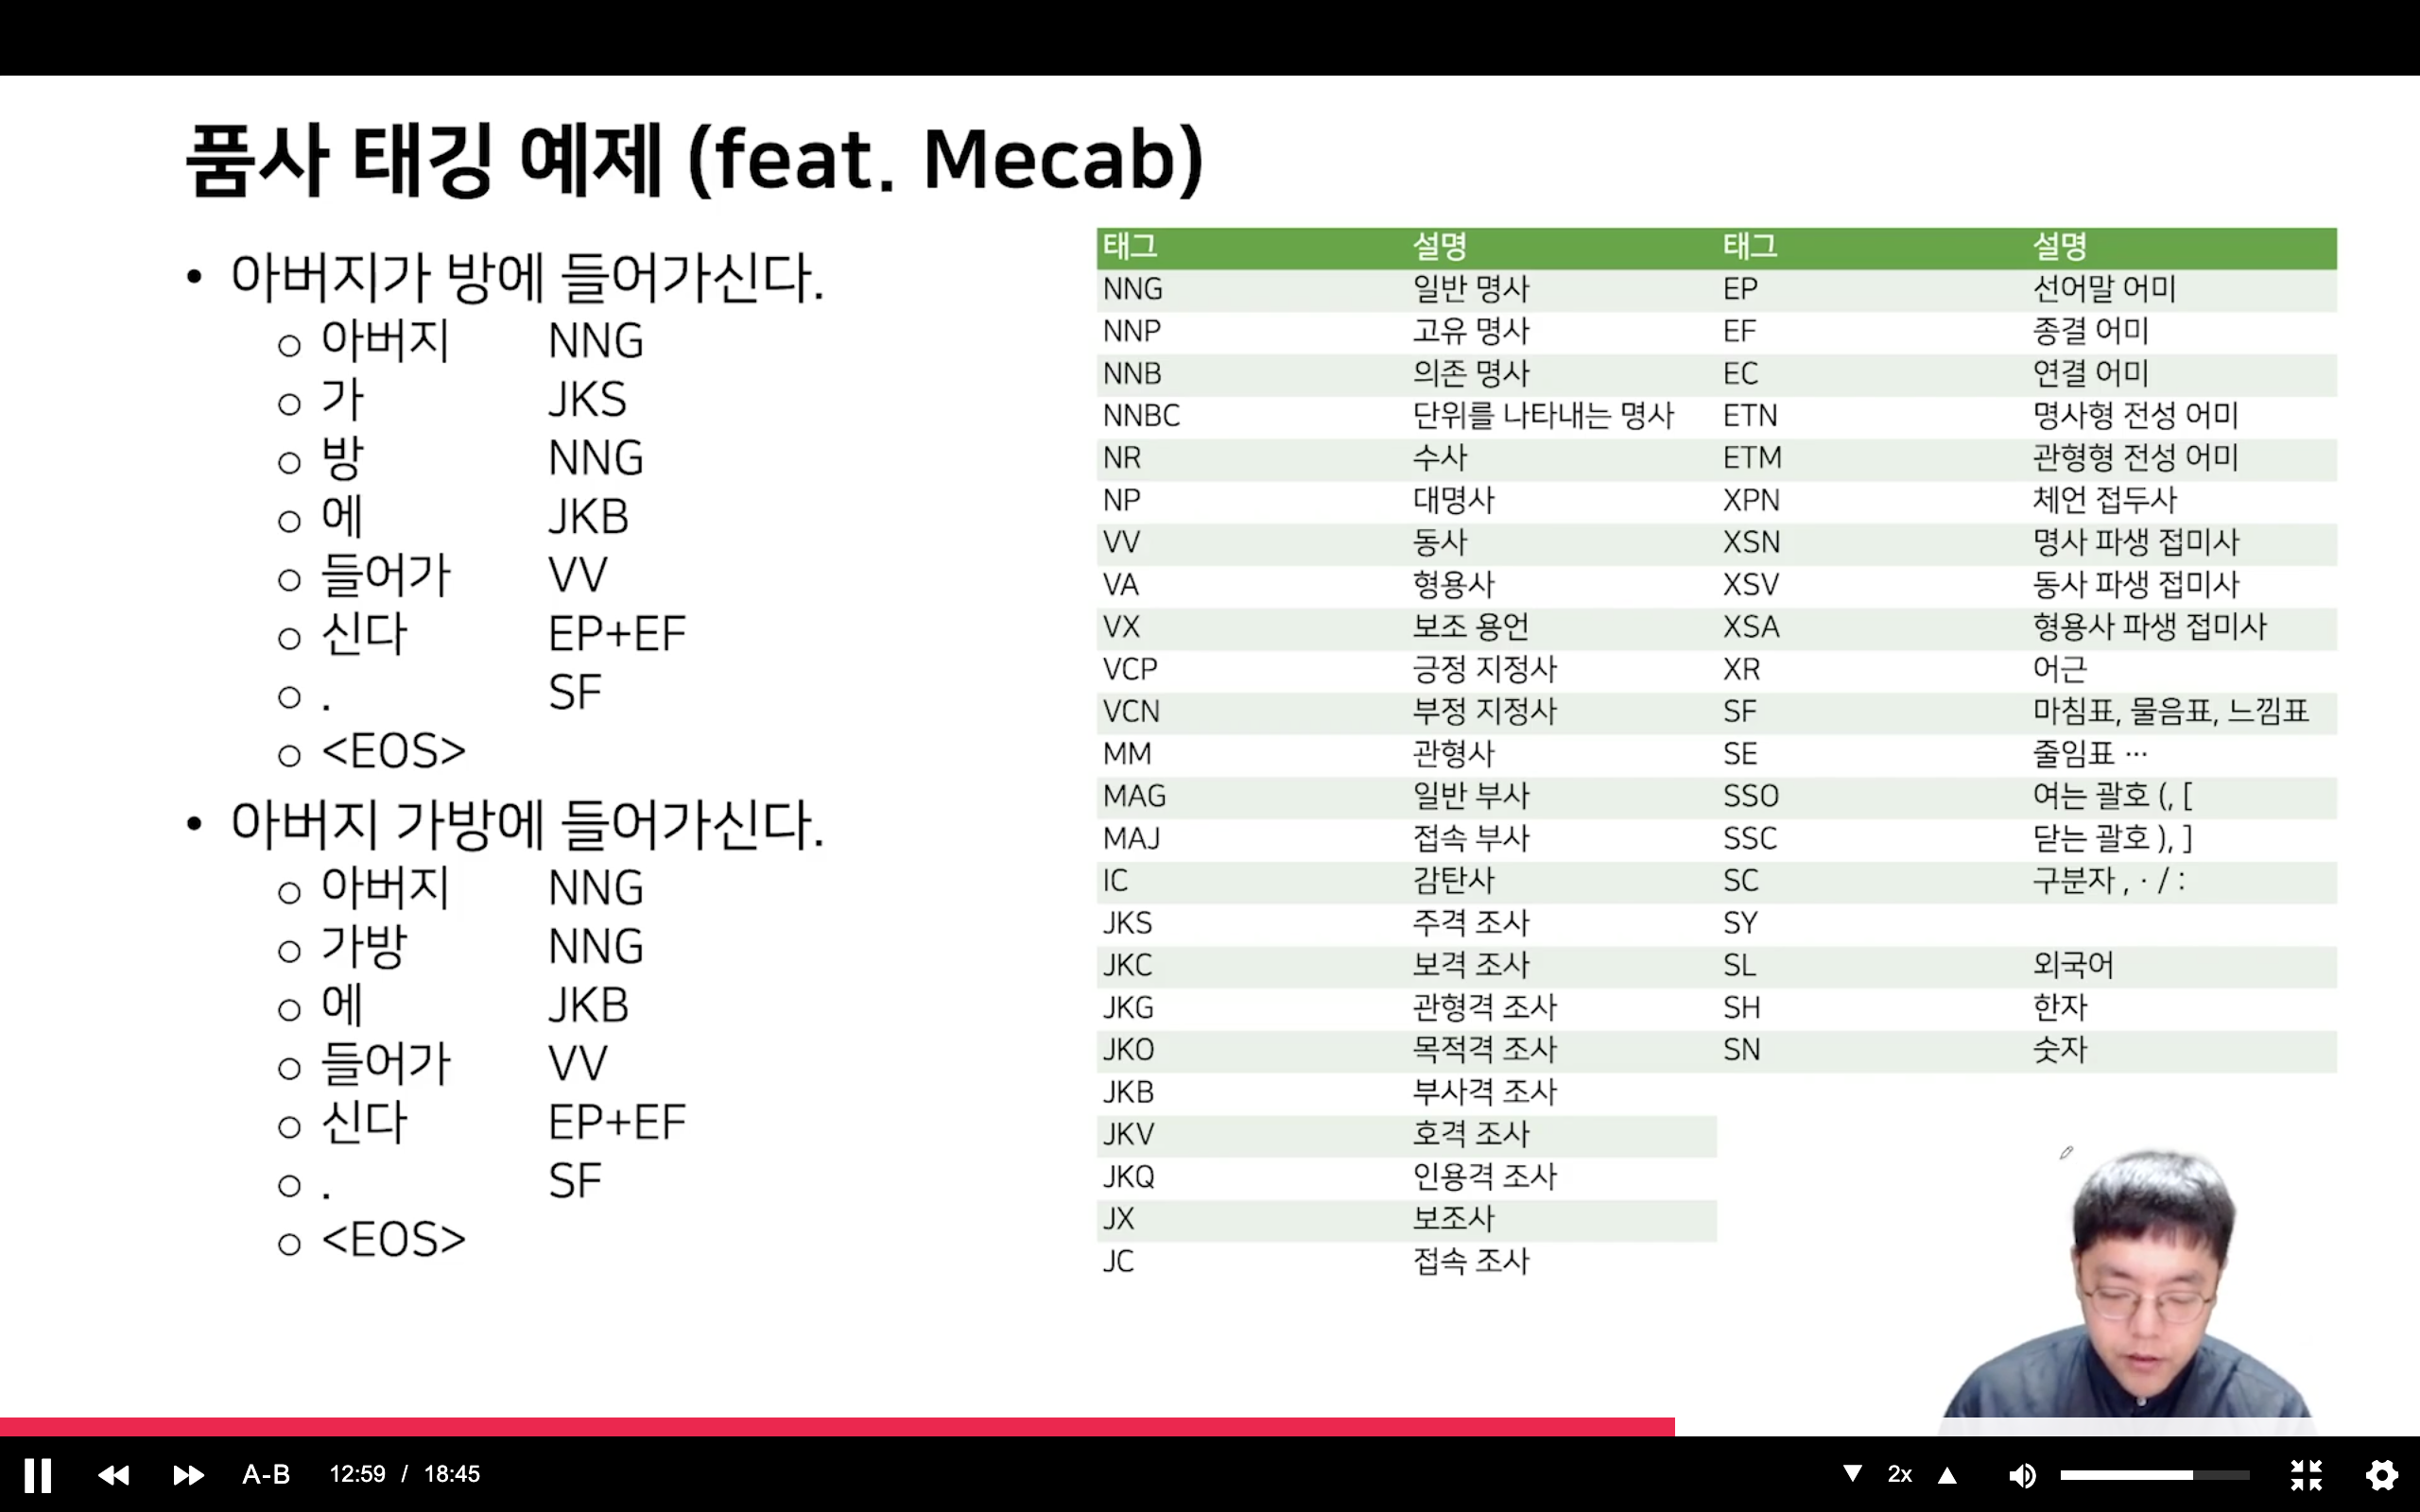

## 1-2. Okt()

In [ ]:
from konlpy.tag import Okt
Okt = Okt()

In [ ]:
# 예시 1) 형태소 단위로 문장 분리
result = Okt.morphs(train_data_content2[0]) ## 결과: 문장이 끊기는 부분도 '\n'으로 따로 분리해줌
print(result)

# 예시 2) 문장에서 명사 추출
result1 = Okt.nouns(train_data_content2[0])
print(result1)

# 예시 3) 품사 태깅(PoS)
result3 = Okt.pos(train_data_content2[0]) ## 태깅이 명사, 형용사, 동사, 조사, 그 외 등으로 단순하고 직관적이어 보임
print(result3)

['기분', '이', '좋지', '않아', '\n', '기분', '이', '좋지', '않은', '이유', '를', '알', '수', '있을까요', '?', '\n', '요새', '건강검진', '을', '받았는데', '건강', '상태', '가', '좋지', '않아', '.', '\n', '많이', '속상하시겠어요', '.', '어디가', '안', '좋은가요', '?', '\n', '이', '곳', '저', '곳', '관리', '해야', '할', '곳', '이', '많아', '.', '\n', '안좋은', '곳', '이', '많아', '걱정', '이', '많으시겠어요', '.', '\n']
['기분', '기분', '이유', '알', '수', '요새', '건강검진', '건강', '상태', '어디가', '안', '곳', '곳', '관리', '곳', '곳', '걱정']
[('기분', 'Noun'), ('이', 'Josa'), ('좋지', 'Adjective'), ('않아', 'Verb'), ('\n', 'Foreign'), ('기분', 'Noun'), ('이', 'Josa'), ('좋지', 'Adjective'), ('않은', 'Verb'), ('이유', 'Noun'), ('를', 'Josa'), ('알', 'Noun'), ('수', 'Noun'), ('있을까요', 'Adjective'), ('?', 'Punctuation'), ('\n', 'Foreign'), ('요새', 'Noun'), ('건강검진', 'Noun'), ('을', 'Josa'), ('받았는데', 'Verb'), ('건강', 'Noun'), ('상태', 'Noun'), ('가', 'Josa'), ('좋지', 'Adjective'), ('않아', 'Verb'), ('.', 'Punctuation'), ('\n', 'Foreign'), ('많이', 'Adverb'), ('속상하시겠어요', 'Adjective'), ('.', 'Punctuation'), ('어디가', 'Noun'), ('안', 'Noun')

## 1-3. Mecab()

In [ ]:
! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)


In [ ]:
# Exception: Install MeCab in order to use it: http://konlpy.org/en/latest/install/

from konlpy.tag import Mecab 
Mecab  = Mecab()

Exception: ignored

In [ ]:
# 예시 1) 형태소 단위로 문장 분리
result = Mecab.morphs(train_data_content2[0])
print(result)

# 예시 2) 문장에서 명사 추출
result1 = Mecab.nouns(train_data_content2[0])
print(result1)

# 예시 3) 품사 태깅(PoS)
result3 = Mecab.pos(train_data_content2[0])
print(result3)

TypeError: ignored

## (?)카카오에서 만든 khaiii 적용?
(깃헙 주소: https://github.com/kakao/khaiii)
(kakaoTech: https://tech.kakao.com/2018/12/13/khaiii/)

- 데이터 기반(Data-Driven) 이라 좋은 거 같으나, 완전 pos 품사 태깅 용 같아서 우리 분류 과제보다는 문서 요약 추출??(n-gram 같은 것과 함께 푸는 task) 에 적합할 것 같음

# 불용어 제거 (Stopwords removing)

In [ ]:
# 데이콘 예시 -불용어 제거 & 제외문자 제거 하면서, 토크나이저(형태소 단위 문장 분리) 같이 함
import re
from konlpy.tag import Okt
tokenizer = Okt()

def text_preprocessing(text,tokenizer):
    
    stopwords = ['을', '를', '이', '가', '은', '는'] ## 우리가 불용어 사전 만들 수 있음
    
    txt = re.sub('[^가-힣a-z]', ' ', text) ## 현재는 영어소문자 & 한글 제외 모든 문자 제거
    token = tokenizer.morphs(txt)
    token = [t for t in token if t not in stopwords]
        
    return token

ex_text = "이번에 새롭게 개봉한 영화의 배우들은 모두 훌륭한 연기력과 아름다운 목소리를 갖고 있어!!"
example_pre= text_preprocessing(ex_text,tokenizer)


print(example_pre)

['이번', '에', '새롭게', '개봉', '한', '영화', '의', '배우', '들', '모두', '훌륭한', '연기력', '과', '아름다운', '목소리', '갖고', '있어']


In [ ]:
# 적용해보기
import re

In [ ]:
#### 데이터 불러오기
# json 딕셔너리 파일에서 content 데이터만 추출

import json # import json module

train_data = []
train_data_content = []

train_y = []


# train data - 대화내용 'content' & emotion 'type'불러오기
with open(train_path) as json_file:
    json_data = json.load(json_file)

    for i in json_data: # i : dict
        temp = (i.get('talk')).get('content')
        
        if '' not in temp:
            train_data.append(temp) # "content" 만
            
            train_data_content.append(list(temp.values()))
            
            #for v1 in temp.values():
            #    train_data_content += v1
            
            train_y.append(((i.get('profile')).get('emotion')).get('type'))
        
        
    print(train_data[:5], type(train_data[0]))
    print()
    print(train_y[:5], type(train_y[0]))
    print()
    print(train_data_content[:5], type(train_data_content[0]))



[{'HS01': '기분이 좋지 않아', 'SS01': '기분이 좋지 않은 이유를 알 수 있을까요?', 'HS02': '요새 건강검진을 받았는데 건강 상태가 좋지 않아.', 'SS02': '많이 속상하시겠어요. 어디가 안 좋은가요?', 'HS03': '이곳 저곳 관리해야 할 곳이 많아.', 'SS03': '안좋은 곳이 많아 걱정이 많으시겠어요.'}, {'HS01': '진로가 너무 걱정스러워. 내가 진짜 뭘 해야 할지 모르겠어.', 'SS01': '미래가 두려우시군요. 하고 싶은 일이 있으세요?', 'HS02': '하고 싶은 일은 있는데 지금 시작하기에 너무 늦은 것 같아서 선뜻 도전을 못 하겠어.', 'SS02': '도전하는 것에 두려움을 느끼고 계시네요.', 'HS03': '', 'SS03': ''}, {'HS01': '아이가 친구랑 다퉈서 걱정이야.', 'SS01': '걱정이 되시겠군요. 아이는 어떤 상태인가요?', 'HS02': '아이도 걱정이 되는지 밥도 잘 안먹더라고.', 'SS02': '많이 걱정되시겠어요. 어떻게 하면 아이를 도와줄 수 있을까요?', 'HS03': '저녁먹고 대화를 해봐야지.', 'SS03': '대화가 잘 되었으면 좋겠어요.'}, {'HS01': '나 요새 친구들이랑 대화하는 게 어려워.', 'SS01': '친구들과 대화하는 것이 어려운 이유가 있을까요?', 'HS02': '친구가 날 안좋아 할지 걱정되고 내가 말실수는 하지 않았을까 두려워.', 'SS02': '친구와 대화하기 힘들어 많이 괴로우시겠어요.', 'HS03': '너무 속상하고 불편해.', 'SS03': '친구와 다시 편하게 대화하길 바라고 계시는군요.'}, {'HS01': '결혼 후 맞벌이를 하고 있는데 은퇴를 생각하면 어렵네.', 'SS01': '은퇴를 생각하며 걱정이 되시는군요. 은퇴를 위해 준비하신 게 있으신가요?', 'HS02': '노후대비를 생각해서 연금 저축을 들어놓은 게 있어.', 'SS02': '잘 준비하셨네요. 마음은 편안하신가요?', 'HS03': '

In [ ]:
# train_data_content list -> str 로 이어붙이기

train_data_content2 = []

for idx in range(len(train_data_content)):
    train_data_content2.append('')
    
    for elem in train_data_content[idx]:
        train_data_content2[idx] += elem + '\n' # nltk 라이브러리 쓰는 거 실패해서 야매로 여기서라도 줄 바꿔줌
        
print(train_data_content2[:2])    

['기분이 좋지 않아\n기분이 좋지 않은 이유를 알 수 있을까요?\n요새 건강검진을 받았는데 건강 상태가 좋지 않아.\n많이 속상하시겠어요. 어디가 안 좋은가요?\n이곳 저곳 관리해야 할 곳이 많아.\n안좋은 곳이 많아 걱정이 많으시겠어요.\n', '진로가 너무 걱정스러워. 내가 진짜 뭘 해야 할지 모르겠어.\n미래가 두려우시군요. 하고 싶은 일이 있으세요?\n하고 싶은 일은 있는데 지금 시작하기에 너무 늦은 것 같아서 선뜻 도전을 못 하겠어.\n도전하는 것에 두려움을 느끼고 계시네요.\n\n\n']


In [ ]:
stopwords = ['을', '를', '이', '가', '은', '는'] ## 우리가 불용어 사전 만들 수 있음

#train_data_content2[1] = re.sub('[^가-힣a-z]', ' ', train_data_content2[1]) ## 현재는 영어소문자 & 한글 제외 모든 문자 제거
#token = [t for t in token if t not in stopwords]

for stop in stopwords:
  train_data_content2[0] = train_data_content2[0].replace(stop, '', )

In [ ]:
train_data_content2[0]

'기분 좋지 않아\n기분 좋지 않 유 알 수 있까요?\n요새 건강검진 받았데 건강 상태 좋지 않아.\n많 속상하시겠어요. 어디 안 좋요?\n곳 저곳 관리해야 할 곳 많아.\n안좋 곳 많아 걱정 많으시겠어요.\n'

# 서브워드 분절(Subword Segmentation)

In [ ]:
# Sentencepiece: 서브워드 분절(Subword Segmentation) Modules 중 하나
!pip install -U sentencepiece

  Using cached sentencepiece-0.1.94-cp38-cp38-macosx_10_6_x86_64.whl (1.1 MB)
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.91
    Uninstalling sentencepiece-0.1.91:
      Successfully uninstalled sentencepiece-0.1.91
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 3.5.0 requires sentencepiece==0.1.91, but you have sentencepiece 0.1.94 which is incompatible.
dialognlu 0.2.0 requires scipy>=1.5.2, but you have scipy 1.4.1 which is incompatible.


**한국어의 경우,**
- 띄어쓰기가 제멋대로인 경우가 많으므로 normalization 없이 바로 Subword Segmentation을 적용하는 것은 위험
- 따라서 형태소 분석기(Mecab 등)를 통한 Tokenization을 진행한 이후, Subword Segmentation을 적용하는 것을 권장 !

# 감정분류표에 맞게 class label 값 숫자로 치환 (0~59)

In [ ]:
# 소 분류
emotion_code = {f'E{i+10}': i for i in range(60)}

In [ ]:
# train
train_labels = []
for elem1 in train_y:
    for k, v in emotion_code.items():
        if elem1 == k:
            train_labels.append(v)
            #print(elem1)

In [ ]:
# valid
validation_labels = []
for elem2 in valid_y:
    for k, v in emotion_code.items():
        if elem2 == k:
            validation_labels.append(v)

In [ ]:
print(train_labels[:10])
print(validation_labels[:10])

[27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
[27, 27, 27, 27, 27, 14, 21, 3, 14, 26]


In [ ]:
print(len(train_labels), len(validation_labels)) # okay !

15832 1717


In [ ]:
# 대 분류
import math

large_emotion_code = {f'E{i+10}': math.floor(i//10) for i in range(60)}
print(large_emotion_code)

{'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E17': 0, 'E18': 0, 'E19': 0, 'E20': 1, 'E21': 1, 'E22': 1, 'E23': 1, 'E24': 1, 'E25': 1, 'E26': 1, 'E27': 1, 'E28': 1, 'E29': 1, 'E30': 2, 'E31': 2, 'E32': 2, 'E33': 2, 'E34': 2, 'E35': 2, 'E36': 2, 'E37': 2, 'E38': 2, 'E39': 2, 'E40': 3, 'E41': 3, 'E42': 3, 'E43': 3, 'E44': 3, 'E45': 3, 'E46': 3, 'E47': 3, 'E48': 3, 'E49': 3, 'E50': 4, 'E51': 4, 'E52': 4, 'E53': 4, 'E54': 4, 'E55': 4, 'E56': 4, 'E57': 4, 'E58': 4, 'E59': 4, 'E60': 5, 'E61': 5, 'E62': 5, 'E63': 5, 'E64': 5, 'E65': 5, 'E66': 5, 'E67': 5, 'E68': 5, 'E69': 5}


In [ ]:
# train
train_labels_large = []
for elem1 in train_y:
    for k, v in large_emotion_code.items():
        if elem1 == k:
            train_labels_large.append(v)
            #print(elem1)

In [ ]:
# valid
validation_labels_large = []
for elem2 in valid_y:
    for k, v in large_emotion_code.items():
        if elem2 == k:
            validation_labels_large.append(v)

In [ ]:
print(train_labels_large[:10])
print(validation_labels_large[:10])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 1, 2, 0, 1, 2]


In [ ]:
print(len(train_labels_large), len(validation_labels_large)) # okay !

15832 1717


# y_data categorical 인코딩

In [ ]:
## 소 분류

In [ ]:
train_labels = to_categorical(train_labels)
train_labels.shape

(15832, 60)

In [ ]:
validation_labels = to_categorical(validation_labels)
validation_labels.shape

(1717, 60)

In [ ]:
train_labels[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
validation_labels[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
## 대 분류

In [ ]:
train_labels_large = to_categorical(train_labels_large)
train_labels_large.shape

(15832, 6)

In [ ]:
validation_labels_large = to_categorical(validation_labels_large)
validation_labels_large.shape

(1717, 6)

In [ ]:
train_labels_large[:10]

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
validation_labels_large[:10]

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

# 데이터 전처리

# Tokenizing

- Albert Pretrain 시키기 - kobert(monologg) 사용

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertModel, DistilBertModel
bert_model = BertModel.from_pretrained('monologg/kobert')
distilbert_model = DistilBertModel.from_pretrained('monologg/distilkobert')

In [ ]:
!pip install kobert_transformers

In [ ]:
import torch
from kobert_transformers import get_kobert_model, get_distilkobert_model
model = get_distilkobert_model() # 변화 - distil 코버트 사용
model.eval()
#input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
#attention_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
#token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
#sequence_output, pooled_output = model(input_ids, attention_mask, token_type_ids)
#sequence_output[0]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in

In [ ]:
print(model)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in

In [ ]:
# 1) transfer 그대로 평가???

In [ ]:
# 파이토치 임포트


In [ ]:
# 2) 단어 사전만 활용해서 새로 토크나이징+모델링 ??

In [ ]:
from kobert_transformers import get_tokenizer
tokenizer = get_tokenizer()
tokenizer.tokenize("[CLS] 한국어 모델을 공유합니다. [SEP]")

['[CLS]', '▁한국', '어', '▁모델', '을', '▁공유', '합니다', '.', '[SEP]']

In [ ]:
# 토큰화 + 숫자 치환(Word 2 Index)

# train
train_sequences =[]

for a in range(len(train_data_content2)):
    train_sequences.append(tokenizer.tokenize(train_data_content2[a]))
    train_sequences[a] = tokenizer.convert_tokens_to_ids(train_sequences[a])


# valid
valid_sequences =[]

for b in range(len(valid_data_content2)):
    valid_sequences.append(tokenizer.tokenize(valid_data_content2[b]))
    valid_sequences[b] = tokenizer.convert_tokens_to_ids(valid_sequences[b])

In [ ]:
train_sequences[:5]

[[1282,
  7096,
  4210,
  3155,
  5561,
  6416,
  7096,
  4210,
  3162,
  3735,
  3166,
  2872,
  3881,
  6999,
  258,
  6999,
  6536,
  882,
  5392,
  7344,
  7088,
  2229,
  5761,
  882,
  2680,
  5330,
  4210,
  3155,
  54,
  6158,
  7096,
  2856,
  6527,
  7782,
  6705,
  5405,
  6857,
  54,
  3223,
  5330,
  3135,
  4209,
  5330,
  6999,
  258,
  7096,
  5451,
  3990,
  5451,
  1088,
  7852,
  4977,
  1022,
  1952,
  54,
  6812,
  7272,
  1022,
  1952,
  880,
  7096,
  517,
  6158,
  7074,
  6705,
  5405,
  6857,
  54],
 [4360,
  6079,
  5330,
  1458,
  880,
  6668,
  54,
  1435,
  4368,
  517,
  6249,
  5010,
  4977,
  7318,
  2049,
  5405,
  6855,
  54,
  6258,
  5330,
  1773,
  6060,
  7005,
  6705,
  5512,
  6999,
  54,
  4926,
  3075,
  3818,
  3854,
  7074,
  6586,
  258,
  7788,
  3075,
  3803,
  7086,
  3861,
  4299,
  2986,
  7789,
  6896,
  1458,
  517,
  5767,
  7086,
  905,
  832,
  6553,
  2734,
  5997,
  1721,
  7088,
  2086,
  4924,
  5405,
  6855,
  54,
  5859,
  7

In [ ]:
valid_sequences[:5]

[[1493,
  7289,
  4927,
  5330,
  4102,
  3231,
  5702,
  54,
  7234,
  7126,
  880,
  7096,
  2145,
  6586,
  258,
  5866,
  7096,
  4128,
  7126,
  2125,
  6844,
  54,
  7323,
  1493,
  7289,
  4926,
  980,
  6733,
  5384,
  5330,
  6999,
  258,
  7202,
  5550,
  7098,
  517,
  7200,
  7088,
  4924,
  5584,
  5018,
  3252,
  3135,
  5886,
  5771,
  2125,
  7318,
  54,
  7200,
  7088,
  5002,
  1239,
  7203,
  517,
  6835,
  6630,
  4005,
  5398,
  831,
  5439,
  2705,
  7782,
  6705,
  5760,
  5512,
  6999,
  54],
 [1397,
  5330,
  1788,
  5771,
  882,
  7096,
  880,
  6668,
  54,
  4626,
  7828,
  4627,
  5330,
  3177,
  6896,
  889,
  6072,
  5377,
  5928,
  54,
  7489,
  5495,
  5330,
  3177,
  6896,
  889,
  6060,
  6553,
  882,
  6896,
  1682,
  880,
  7096,
  1952,
  7318,
  6604,
  5512,
  6999,
  54,
  517,
  7930,
  6705,
  4299,
  3093,
  7760,
  1022,
  3854,
  7074,
  6733,
  5330,
  6999,
  258,
  6797,
  5770,
  54,
  3093,
  7760,
  1021,
  7086,
  3272,
  5850,
  882,

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer # 전처리 관련
from tensorflow.keras.preprocessing.sequence import pad_sequences # 전처리 관련

In [ ]:
# 시퀀스의 길이를 맞춰주기

# 한 문장의 최대 단어 숫자
max_len = 500

# 잘라낼 문장의 위치
trunc_type='post'

# 채워줄 문장의 위치
padding_type='post' # 'post' -> 뒷 부분 , 'pre' -> 앞 부분

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_len, truncating=trunc_type, padding=padding_type)
# train_sentences 말고 숫자로 변환된 train_sequences를 넣어야 ! # truncating 옵션 : max_length 길이를 넘는 단어를 잘라내주는 옵션 (여기서는 'post'(뒤) 를 잘라냄) 
# padding 옵션 : max_length 길이 보다 짧은 단어는 값을 채워주는 옵션
validation_padded = pad_sequences(valid_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [ ]:
train_padded.shape # (train 분할 단위 , max_length)
#type(train_padded)

(15832, 500)

In [ ]:
train_padded.shape # (train 분할 단위 , max_length)
#type(train_padded)

(15832, 500)

In [ ]:
train_padded.shape # (train 분할 단위 , max_length)
#type(train_padded)

(15832, 500)

# 데이터 shuffle
-x_train과 y_train을 배열로 묶어주고 shuffle ->> 그 결과를 다시 x_train, y_train 으로 나눈다

In [ ]:
## 소 분류

In [ ]:
tmp = [[x,y] for x, y in zip(train_padded, train_labels)]
tmp[:10]

[[array([1282, 7096, 4210, 3155, 5561, 6416, 7096, 4210, 3162, 3735, 3166,
         2872, 3881, 6999,  258, 6999, 6536,  882, 5392, 7344, 7088, 2229,
         5761,  882, 2680, 5330, 4210, 3155,   54, 6158, 7096, 2856, 6527,
         7782, 6705, 5405, 6857,   54, 3223, 5330, 3135, 4209, 5330, 6999,
          258, 7096, 5451, 3990, 5451, 1088, 7852, 4977, 1022, 1952,   54,
         6812, 7272, 1022, 1952,  880, 7096,  517, 6158, 7074, 6705, 5405,
         6857,   54,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0

In [ ]:
import random
random.shuffle(tmp)
tmp[:10]

[[array([1347, 3673, 3093, 5944, 6273, 5944, 2644, 6844, 6150, 4977, 5591,
          517, 6751, 5439, 3498, 7013, 7798,   54, 1730, 3219, 7798, 4628,
         5468, 3076, 7036, 6855,   54, 6158, 7096, 2856, 6527, 7782, 5405,
         6857,   54, 2934, 4999, 7789, 5212, 2127, 1958, 7104, 5007, 4889,
         5678, 6198, 4204, 5405, 6857,   54, 5538, 6049, 5400, 1965, 7303,
         6553,  993, 6141, 7018,   54, 3225, 5928, 5211, 5678, 6553, 2644,
         6394, 7318,   54, 5561, 6416, 7096, 4164, 7104, 1370, 6797, 7250,
         5770, 1562, 7881, 7096, 6896, 6999,   54, 3245, 5929, 3224, 3714,
         5929, 4924, 6037,  517, 6983, 6999,   54,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0

In [ ]:
train_padded = [n[0] for n in tmp]
train_labels = [n[1] for n in tmp]

In [ ]:
# check
train_padded[:10]

[array([1347, 3673, 3093, 5944, 6273, 5944, 2644, 6844, 6150, 4977, 5591,
         517, 6751, 5439, 3498, 7013, 7798,   54, 1730, 3219, 7798, 4628,
        5468, 3076, 7036, 6855,   54, 6158, 7096, 2856, 6527, 7782, 5405,
        6857,   54, 2934, 4999, 7789, 5212, 2127, 1958, 7104, 5007, 4889,
        5678, 6198, 4204, 5405, 6857,   54, 5538, 6049, 5400, 1965, 7303,
        6553,  993, 6141, 7018,   54, 3225, 5928, 5211, 5678, 6553, 2644,
        6394, 7318,   54, 5561, 6416, 7096, 4164, 7104, 1370, 6797, 7250,
        5770, 1562, 7881, 7096, 6896, 6999,   54, 3245, 5929, 3224, 3714,
        5929, 4924, 6037,  517, 6983, 6999,   54,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
type(train_padded)

list

In [ ]:
train_labels[:10]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

In [ ]:
# check
print(train_labels[0].shape, validation_labels[0].shape)

(60,) (60,)


In [ ]:
## 대 분류

In [ ]:
tmp2 = [[x,y] for x, y in zip(train_padded, train_labels_large)]
tmp2[:10]

[[array([1347, 3673, 3093, 5944, 6273, 5944, 2644, 6844, 6150, 4977, 5591,
          517, 6751, 5439, 3498, 7013, 7798,   54, 1730, 3219, 7798, 4628,
         5468, 3076, 7036, 6855,   54, 6158, 7096, 2856, 6527, 7782, 5405,
         6857,   54, 2934, 4999, 7789, 5212, 2127, 1958, 7104, 5007, 4889,
         5678, 6198, 4204, 5405, 6857,   54, 5538, 6049, 5400, 1965, 7303,
         6553,  993, 6141, 7018,   54, 3225, 5928, 5211, 5678, 6553, 2644,
         6394, 7318,   54, 5561, 6416, 7096, 4164, 7104, 1370, 6797, 7250,
         5770, 1562, 7881, 7096, 6896, 6999,   54, 3245, 5929, 3224, 3714,
         5929, 4924, 6037,  517, 6983, 6999,   54,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0

In [ ]:
import random
random.shuffle(tmp2)
tmp2[:10]

[[array([3604, 5176, 7095,  991, 3676, 6063, 1730, 7096, 1956, 4923, 5850,
          517, 5499, 7350, 7096, 1370, 5702,   54, 7086, 7640,  991, 2813,
         6199,  517, 5499, 7350, 7096, 1370, 6604, 5512, 6999,   54, 1185,
         3732, 6896, 1686, 1961, 7848, 4213, 6738, 2872, 3854, 7074, 6733,
         5330, 6999,  258, 7774, 6999, 7828, 1731, 2044, 7074, 5760, 1706,
          889, 6124, 2962, 5468, 1482,  983, 7848, 2421, 5838, 4223, 5859,
         2923, 7318, 3149, 3803, 7848, 5859, 5213, 5782, 5760,  983, 7096,
         1395, 6855,   54, 2913,  517, 5499, 7350, 7096, 1395, 6855,   54,
         7276, 6160, 5592, 2923, 7318, 3149, 3604, 5592, 3803, 7852, 5007,
          517, 5499, 7350, 7096, 1388, 6604, 5512, 6999,   54,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0

In [ ]:
train_padded = [n[0] for n in tmp2]
train_labels_large = [n[1] for n in tmp2]

In [ ]:
# check
train_padded[:10]

[array([3604, 5176, 7095,  991, 3676, 6063, 1730, 7096, 1956, 4923, 5850,
         517, 5499, 7350, 7096, 1370, 5702,   54, 7086, 7640,  991, 2813,
        6199,  517, 5499, 7350, 7096, 1370, 6604, 5512, 6999,   54, 1185,
        3732, 6896, 1686, 1961, 7848, 4213, 6738, 2872, 3854, 7074, 6733,
        5330, 6999,  258, 7774, 6999, 7828, 1731, 2044, 7074, 5760, 1706,
         889, 6124, 2962, 5468, 1482,  983, 7848, 2421, 5838, 4223, 5859,
        2923, 7318, 3149, 3803, 7848, 5859, 5213, 5782, 5760,  983, 7096,
        1395, 6855,   54, 2913,  517, 5499, 7350, 7096, 1395, 6855,   54,
        7276, 6160, 5592, 2923, 7318, 3149, 3604, 5592, 3803, 7852, 5007,
         517, 5499, 7350, 7096, 1388, 6604, 5512, 6999,   54,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
type(train_padded)

list

In [ ]:
train_labels_large[:10]

[array([0., 0., 0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0.], dtype=float32),
 array([0., 0., 0., 1., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 0., 0., 1.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0.], dtype=float32)]

# 모델링

In [ ]:
## 사전 조정 (소 분류)

train_input = np.array(train_padded)
train_labels = np.array(train_labels)

test_input = np.array(validation_padded)
test_labels = np.array(validation_labels)



print(train_input.shape, train_labels.shape, test_input.shape, test_labels.shape)

(15832, 500) (15832, 60) (1717, 500) (1717, 60)


In [ ]:
##### 임포트
from keras import optimizers, losses
from keras.optimizers import Adam, SGD

In [ ]:
vocab_size =8002
embedding_dim = 64

In [ ]:
##### 모델 4 -캐글 TCN
# https://www.kaggle.com/abhiramanand/project-tcn


####
'''
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    
    #tf.keras.layers.Conv1D(filters=64, kernel_size=20,strides=10,padding='valid'), #kernel_size=10

    tf.keras.layers.Conv1D(filters=1024, kernel_size=50,strides=1,padding='causal', activation='relu'), #kernel_size=100
    
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.GlobalAveragePooling1D(),
    
    
    tf.keras.layers.Dense(60, activation='softmax')
])
'''

"\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),\n    \n    #tf.keras.layers.Conv1D(filters=64, kernel_size=20,strides=10,padding='valid'), #kernel_size=10\n\n    tf.keras.layers.Conv1D(filters=1024, kernel_size=50,strides=1,padding='causal', activation='relu'), #kernel_size=100\n    \n    #tf.keras.layers.Dense(512, activation='relu'),\n    tf.keras.layers.Dense(64, activation='relu'),\n    #tf.keras.layers.Dense(512, activation='relu'),\n    \n    tf.keras.layers.GlobalAveragePooling1D(),\n    \n    \n    tf.keras.layers.Dense(60, activation='softmax')\n])\n"

In [ ]:
#### 수정

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    
    #tf.keras.layers.Conv1D(filters=64, kernel_size=20,strides=10,padding='valid'), #kernel_size=10

    tf.keras.layers.Conv1D(filters=60, kernel_size=20,strides=10,padding='causal', activation='relu'), #kernel_size=100
    
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.GlobalAveragePooling1D(),
    
    
    tf.keras.layers.Dense(60, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 64)           512128    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 60)            76860     
_________________________________________________________________
dense (Dense)                (None, 50, 128)           7808      
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                7740      
Total params: 604,536
Trainable params: 604,536
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# learing rate 옵션 (adam)

#1) SGD
#opt = optimizers.SGD(lr=0.003, momentum=0.0, decay=0.01, nesterov=False)

#2) Adam
opt = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False) # learing rate 옵션

#keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

In [ ]:
# fit model
num_epochs = 10

history = model.fit(train_input, train_labels, 
                    validation_data = (test_input, test_labels),
                    callbacks = [checkpoint],
                    epochs=num_epochs)#, verbose=2) #validation_split=0.2)

Epoch 1/10
495/495 [==============================] - 23s 45ms/step - loss: 4.0962 - acc: 0.0159 - val_loss: 4.0943 - val_acc: 0.0163

Epoch 00001: val_loss improved from inf to 4.09434, saving model to my_checkpoint.ckpt
Epoch 2/10
495/495 [==============================] - 22s 44ms/step - loss: 4.0937 - acc: 0.0189 - val_loss: 4.0951 - val_acc: 0.0163

Epoch 00002: val_loss did not improve from 4.09434
Epoch 3/10
495/495 [==============================] - 22s 44ms/step - loss: 4.0560 - acc: 0.0301 - val_loss: 4.1383 - val_acc: 0.0186

Epoch 00003: val_loss did not improve from 4.09434
Epoch 4/10
495/495 [==============================] - 22s 45ms/step - loss: 3.7795 - acc: 0.0725 - val_loss: 4.3654 - val_acc: 0.0116

Epoch 00004: val_loss did not improve from 4.09434
Epoch 5/10
495/495 [==============================] - 22s 44ms/step - loss: 3.3507 - acc: 0.1454 - val_loss: 4.7836 - val_acc: 0.0140

Epoch 00005: val_loss did not improve from 4.09434
Epoch 6/10
495/495 [==============

In [ ]:
model.load_weights(checkpoint_path) # 가중치 로드

In [ ]:
## 사전 조정 (대 분류)

train_input = np.array(train_padded)
train_labels_large = np.array(train_labels_large)

test_input = np.array(validation_padded)
test_labels_large = np.array(validation_labels_large)



print(train_input.shape, train_labels_large.shape, test_input.shape, test_labels_large.shape)

(15832, 500) (15832, 6) (1717, 500) (1717, 6)


In [ ]:
## 대 분류 추가 학습

In [ ]:
#### 수정 (대분류)
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    
    #tf.keras.layers.Conv1D(filters=64, kernel_size=20,strides=10,padding='valid'), #kernel_size=10

    tf.keras.layers.Conv1D(filters=60, kernel_size=20,strides=10,padding='causal', activation='relu'), #kernel_size=100
    
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.GlobalAveragePooling1D(),
    
    
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
# learing rate 옵션 (adam)

#1) SGD
#opt = optimizers.SGD(lr=0.003, momentum=0.0, decay=0.01, nesterov=False)

#2) Adam
opt = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False) # learing rate 옵션

#keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
#checkpoint_path = 'my_checkpoint.ckpt'
checkpoint2 = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

In [ ]:
# fit model
num_epochs = 10

history = model2.fit(train_input, train_labels_large, 
                    validation_data = (test_input, test_labels_large),
                    callbacks = [checkpoint2],
                    epochs=num_epochs)#, verbose=2) #validation_split=0.2)

Epoch 1/10
495/495 [==============================] - 23s 45ms/step - loss: 1.7936 - acc: 0.1656 - val_loss: 1.7918 - val_acc: 0.1642

Epoch 00001: val_loss improved from inf to 1.79181, saving model to my_checkpoint.ckpt
Epoch 2/10
495/495 [==============================] - 22s 45ms/step - loss: 1.7885 - acc: 0.1832 - val_loss: 1.7933 - val_acc: 0.1701

Epoch 00002: val_loss did not improve from 1.79181
Epoch 3/10
495/495 [==============================] - 22s 45ms/step - loss: 1.5856 - acc: 0.3721 - val_loss: 1.9849 - val_acc: 0.1776

Epoch 00003: val_loss did not improve from 1.79181
Epoch 4/10
495/495 [==============================] - 22s 45ms/step - loss: 1.0225 - acc: 0.6474 - val_loss: 2.5050 - val_acc: 0.1648

Epoch 00004: val_loss did not improve from 1.79181
Epoch 5/10
495/495 [==============================] - 22s 45ms/step - loss: 0.6420 - acc: 0.7945 - val_loss: 3.0529 - val_acc: 0.1677

Epoch 00005: val_loss did not improve from 1.79181
Epoch 6/10
495/495 [==============

In [ ]:
model2.load_weights(checkpoint_path) # 가중치 로드

In [ ]:
#### test 비공개 데이터 예측

In [ ]:
pred = model.predict_proba(test_input)